In [80]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Глобальные переменные
x0 = 1 # Начальное положение
v0 = 1 # Начальная скорость

# Устройства для вычислений (GPU если доступен)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Нейронная сеть для PINN

In [81]:
class PINNModel(nn.Module):
    def __init__(self, hidden_size=20):
        super(PINNModel, self).__init__()
        self.layers_stack = nn.Sequential(
            nn.Linear(1, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        return self.layers_stack(x)

### Аналитическое решение для системы с внешней силой cos(ωt)

In [82]:
import torch

def analytic_solution(t, omega):
    global x0, v0

    # Ensure omega is a tensor
    omega = torch.tensor(omega, dtype=torch.float32)

    # Damping coefficient as a tensor
    gamma = omega / 10.0

    # Damped angular frequency as a tensor
    omega_d = torch.sqrt(omega**2 - gamma**2)

    # Calculate constants A and B using initial conditions
    A = x0
    B = (v0 + gamma * x0) / omega_d

    # Compute exponential, sine, and cosine terms
    exp_term = torch.exp(-gamma * t)
    cos_term = torch.cos(omega_d * t)
    sin_term = torch.sin(omega_d * t)

    # Position as a function of time
    x = exp_term * (A * cos_term + B * sin_term)

    # Вычисление скорости
    v = exp_term * (
        -gamma * (A * cos_term + B * sin_term)
        - A * omega_d * sin_term
        + B * omega_d * cos_term
    )

    # Вычисление ускорения
    a = exp_term * (
        (gamma**2 - omega_d**2) * (A * cos_term + B * sin_term)
        + 2 * gamma * omega_d * (A * sin_term - B * cos_term)
    )

    return x, v, a


### Определяем уравнения для разных формулировок

In [83]:
# 1. Для второй формулировки (второй порядок ОДУ)
def pde_second_order(x, t, omega):
    dxdt = torch.autograd.grad(outputs=x, inputs=t, grad_outputs=torch.ones_like(x), create_graph=True)[0]
    d2xdt2 = torch.autograd.grad(outputs=dxdt, inputs=t, grad_outputs=torch.ones_like(dxdt), create_graph=True)[0]
    F = torch.cos(omega * t)  # Внешняя сила
    residual = d2xdt2 + omega**2 * x - F  # Резидуал уравнения
    return residual, dxdt, d2xdt2

# 2. Для первой системы (первый порядок)
def pde_first_order(x, y, t, omega):
    dxdt = y
    dydt = -omega**2 * x + torch.cos(omega * t)
    return dxdt, dydt

# 3. Для альтернативной первой системы
def pde_alternative(x, y, t, omega):
    dxdt = omega * y + (1/omega) * torch.sin(omega * t)
    dydt = -omega * x
    return dxdt, dydt

### Функция потерь для сравнения

In [84]:
def loss_fn(model, t, omega, formulation=1):
    global x0, v0
    # Получаем решение модели
    if formulation == 1:
        x = model(t)
        res, dxdt, d2xdt2 = pde_second_order(x, t, omega)
        # Вычисляем потерю по уравнению
        loss_pde = torch.mean(res**2)

        # Начальные условия
        t0 = torch.tensor([[0.0]], requires_grad=True).to(device)
        x0_pred = model(t0)
        dxdt0 = torch.autograd.grad(outputs=x0_pred, inputs=t0, grad_outputs=torch.ones_like(x0_pred), create_graph=True)[0]

        # Потеря по начальному условию для x(0)
        loss_ic_x = (x0_pred - x0)**2
        # Потеря по начальному условию для x'(0)
        loss_ic_dxdt = (dxdt0 - v0)**2

        # Общая функция потерь
        loss = loss_pde + loss_ic_x + loss_ic_dxdt
        return loss, x, dxdt, d2xdt2
    elif formulation == 2:
        y = model(t)
        x = y[:, 0:1]
        res1, res2 = pde_first_order(x, y, t, omega)
        return torch.mean(res1**2 + res2**2), x, res1, res2
    elif formulation == 3:
        y = model(t)
        x = y[:, 0:1]
        res1, res2 = pde_alternative(x, y, t, omega)
        return torch.mean(res1**2 + res2**2), x, res1, res2

### Обучение модели

In [85]:
def train_model(formulation, omega, t, epochs=10000, learning_rate=0.001):
    model = PINNModel().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    loss_history = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        loss, x, dxdt, d2xdt2 = loss_fn(model, t, omega, formulation)
        loss.backward()
        optimizer.step()
        
        loss_history.append(loss.item())
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}/{epochs}, Loss: {loss.item()}")
    
    return model, loss_history, x, dxdt, d2xdt2

In [86]:
# Тестирование модели
def test_model(model, t):
    with torch.no_grad():
        x_pred = model(t)
    return x_pred

# Время и параметры для обучения
t = torch.linspace(0, 5, 500).reshape(-1, 1).to(device)  # Вектор времени
t.requires_grad = True
omega = 2 * np.pi * 2  # Частота

# Обучаем модели для разных формулировок
model_1, loss_history_1, x_1, dxdt_1, d2xdt2_1 = train_model(1, omega, t)
model_2, loss_history_2, x_2, dxdt_2, d2xdt2_2 = train_model(2, omega, t)
model_3, loss_history_3, x_3, dxdt_3, d2xdt2_3 = train_model(3, omega, t)

# Тестируем модели
x_pred_1 = test_model(model_1, t)
x_pred_2 = test_model(model_2, t)
x_pred_3 = test_model(model_3, t)

# Получаем аналитические решения для x(t), dx/dt(t), d2x/dt2(t)
x_analytic, dxdt_analytic, d2xdt2_analytic = analytic_solution(t, omega)

Epoch 0/10000, Loss: 2436.609130859375
Epoch 100/10000, Loss: 3.7353219985961914
Epoch 200/10000, Loss: 3.3777642250061035
Epoch 300/10000, Loss: 3.161393642425537
Epoch 400/10000, Loss: 3.0265727043151855
Epoch 500/10000, Loss: 2.9277706146240234
Epoch 600/10000, Loss: 2.846057891845703
Epoch 700/10000, Loss: 2.7759299278259277
Epoch 800/10000, Loss: 2.7160325050354004
Epoch 900/10000, Loss: 2.665783643722534
Epoch 1000/10000, Loss: 2.62454891204834
Epoch 1100/10000, Loss: 2.5915346145629883
Epoch 1200/10000, Loss: 2.565810441970825
Epoch 1300/10000, Loss: 2.5463526248931885
Epoch 1400/10000, Loss: 2.532088279724121
Epoch 1500/10000, Loss: 2.521955966949463
Epoch 1600/10000, Loss: 2.5149645805358887
Epoch 1700/10000, Loss: 2.5102500915527344
Epoch 1800/10000, Loss: 2.5071029663085938
Epoch 1900/10000, Loss: 2.504983425140381
Epoch 2000/10000, Loss: 2.503505229949951
Epoch 2100/10000, Loss: 2.5024075508117676
Epoch 2200/10000, Loss: 2.5015296936035156
Epoch 2300/10000, Loss: 2.50077414

### Визуализация результатов

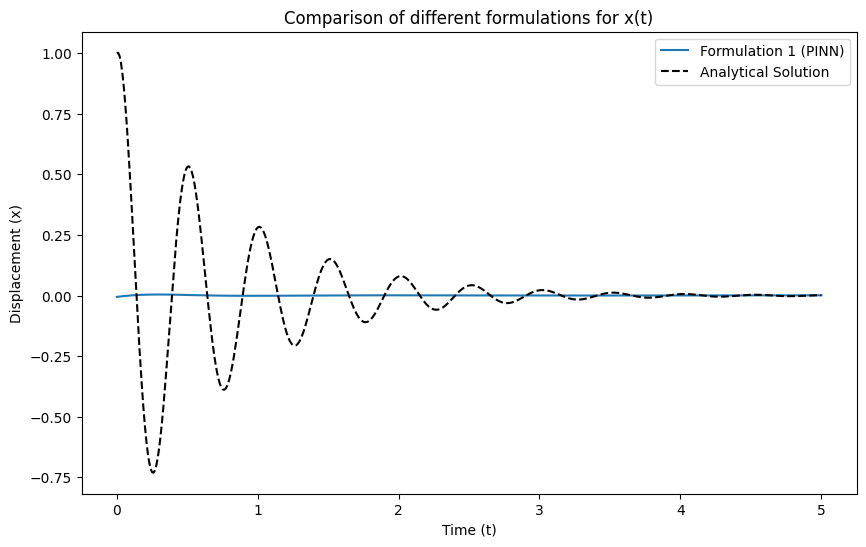

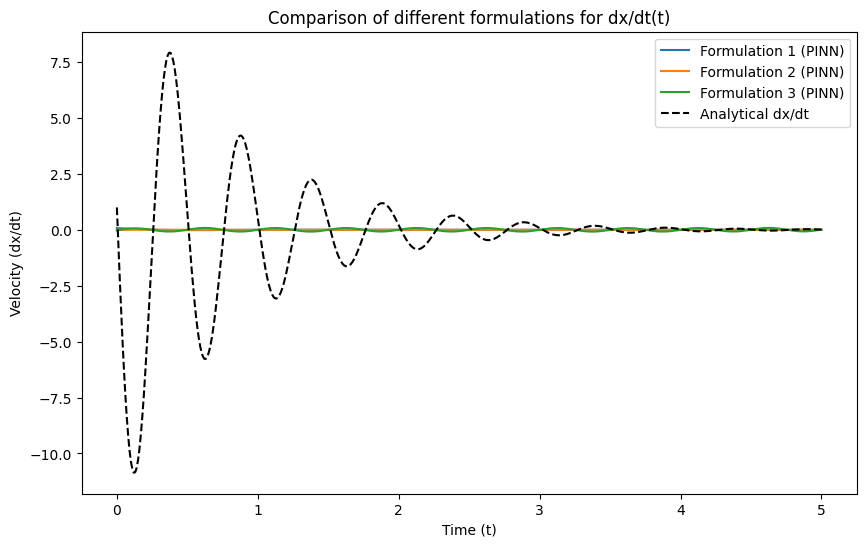

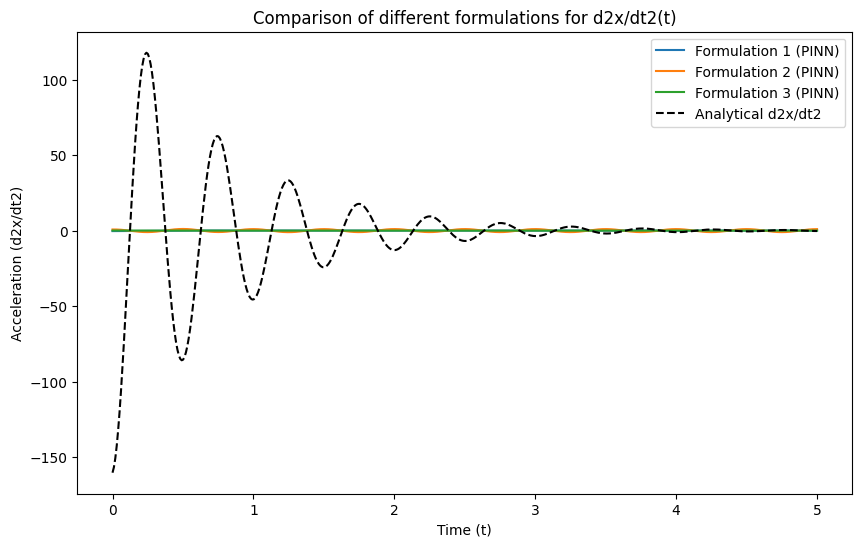

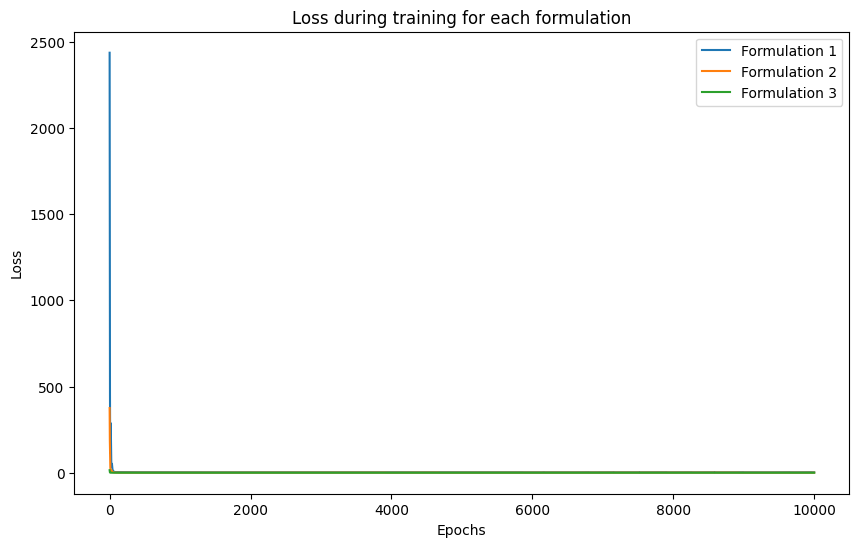

In [87]:
# 1. График x от t для всех формулировок и аналитического решения
plt.figure(figsize=(10, 6))
plt.plot(t.cpu().detach().numpy(), x_pred_1.cpu().detach().numpy(), label='Formulation 1 (PINN)')
#plt.plot(t.cpu().detach().numpy(), x_pred_2.cpu().detach().numpy(), label='Formulation 2 (PINN)')
#plt.plot(t.cpu().detach().numpy(), x_pred_3.cpu().detach().numpy(), label='Formulation 3 (PINN)')
plt.plot(t.cpu().detach().numpy(), x_analytic.cpu().detach().numpy(), label='Analytical Solution', linestyle='dashed', color='black')
plt.legend()
plt.xlabel('Time (t)')
plt.ylabel('Displacement (x)')
plt.title('Comparison of different formulations for x(t)')
plt.savefig('disp2time_comparison_with_analytic.png')
plt.show()

# 2. Зависимость dx/dt от t для всех формулировок и аналитического решения
plt.figure(figsize=(10, 6))
plt.plot(t.cpu().detach().numpy(), dxdt_1.cpu().detach().numpy(), label='Formulation 1 (PINN)')
plt.plot(t.cpu().detach().numpy(), dxdt_2.cpu().detach().numpy(), label='Formulation 2 (PINN)')
plt.plot(t.cpu().detach().numpy(), dxdt_3.cpu().detach().numpy(), label='Formulation 3 (PINN)')
plt.plot(t.cpu().detach().numpy(), dxdt_analytic.cpu().detach().numpy(), label='Analytical dx/dt', linestyle='dashed', color='black')
plt.legend()
plt.xlabel('Time (t)')
plt.ylabel('Velocity (dx/dt)')
plt.title('Comparison of different formulations for dx/dt(t)')
plt.savefig('dxdt_comparison_with_analytic.png')
plt.show()

# 3. Зависимость d2x/dt2 от t для всех формулировок и аналитического решения
plt.figure(figsize=(10, 6))
plt.plot(t.cpu().detach().numpy(), d2xdt2_1.cpu().detach().numpy(), label='Formulation 1 (PINN)')
plt.plot(t.cpu().detach().numpy(), d2xdt2_2.cpu().detach().numpy(), label='Formulation 2 (PINN)')
plt.plot(t.cpu().detach().numpy(), d2xdt2_3.cpu().detach().numpy(), label='Formulation 3 (PINN)')
plt.plot(t.cpu().detach().numpy(), d2xdt2_analytic.cpu().detach().numpy(), label='Analytical d2x/dt2', linestyle='dashed', color='black')
plt.legend()
plt.xlabel('Time (t)')
plt.ylabel('Acceleration (d2x/dt2)')
plt.title('Comparison of different formulations for d2x/dt2(t)')
plt.savefig('d2xdt2_comparison_with_analytic.png')
plt.show()

# 4. График потерь для каждой формулировки
plt.figure(figsize=(10, 6))
plt.plot(loss_history_1, label='Formulation 1')
plt.plot(loss_history_2, label='Formulation 2')
plt.plot(loss_history_3, label='Formulation 3')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss during training for each formulation')
plt.savefig('loss_comparison.png')
plt.show()
